In [2]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset
from glob import glob
from copy import deepcopy
import data_util
import matplotlib.pyplot as plt
import random

from sys import getsizeof

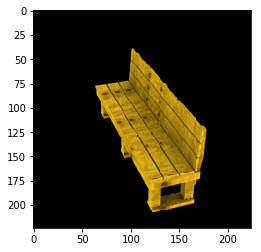

In [7]:
path = os.path.join("/home/max/shapenet", 'train_rgb', 'bench_0_render_0.png')
x = data_util.load_img(path, square_crop=True, downsampling_order=1, target_size=[224, 224])
plt.imshow(x)